## Skin Cancer Classification Transfer Learning DenseNet121

In [2]:
import os
import shutil
from tqdm import tqdm

import cv2
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("classic")

### Creating Dataset

In [2]:
print(os.listdir('../input/ham-dataset/HAM_Dataset'))

['MEL', 'VASC', 'DF', 'NV', 'BKL', 'AKIEC', 'BCC']


### Train Test Split

In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input as base_preprocess


image_gen = ImageDataGenerator(preprocessing_function=base_preprocess,
                               rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               #rescale=1/255,
                               validation_split=0.20)

In [78]:
data_dir = '../input/ham-dataset/HAM_Dataset'
batch_size = 64
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 12085 images belonging to 7 classes.
Found 3019 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


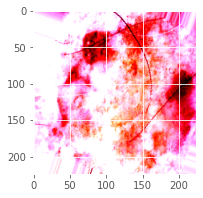

In [80]:
plt.figure(figsize=(3,3))
plt.imshow(train_image_gen[0][0][0])

## Transfer Learning using DenseNet121 Model

In [1]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)


tl_model.summary()
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 230, 230, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________

In [84]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_aug.hdf5',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

### Model Training

In [85]:
history = tl_model.fit(train_image_gen,
                       epochs=20, 
                       validation_data = test_image_gen,
                       callbacks=callback_list)

Epoch 1/20
189/189 [==============================] - 352s 2s/step - loss: 1.7499 - accuracy: 0.4074 - val_loss: 0.9937 - val_accuracy: 0.6615

Epoch 00001: val_accuracy improved from -inf to 0.66148, saving model to best_model_aug.hdf5
Epoch 2/20
189/189 [==============================] - 340s 2s/step - loss: 0.7136 - accuracy: 0.7340 - val_loss: 0.8230 - val_accuracy: 0.7284

Epoch 00002: val_accuracy improved from 0.66148 to 0.72839, saving model to best_model_aug.hdf5
Epoch 3/20
189/189 [==============================] - 339s 2s/step - loss: 0.5030 - accuracy: 0.8223 - val_loss: 0.8826 - val_accuracy: 0.7479

Epoch 00003: val_accuracy improved from 0.72839 to 0.74793, saving model to best_model_aug.hdf5
Epoch 4/20
189/189 [==============================] - 339s 2s/step - loss: 0.3668 - accuracy: 0.8721 - val_loss: 1.0351 - val_accuracy: 0.7440

Epoch 00004: val_accuracy did not improve from 0.74793
Epoch 5/20
189/189 [==============================] - 340s 2s/step - loss: 0.3209 - 

### Model Evaluation

<AxesSubplot:>

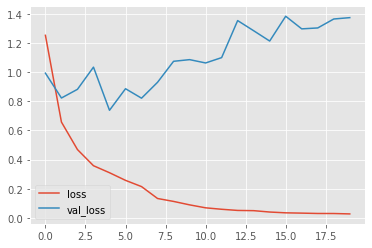

In [87]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<AxesSubplot:>

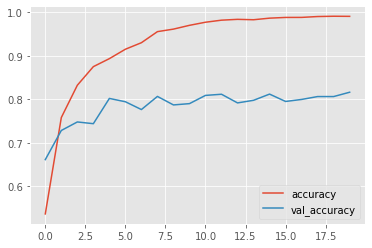

In [88]:
metrics[["accuracy","val_accuracy"]].plot()

In [90]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

48/48 [==============================] - 68s 1s/step


In [91]:
test_labels = test_image_gen.classes

In [1]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)

Normalized confusion matrix
[[0.67346939 0.09183673 0.1505102  0.00510204 0.06632653 0.0127551
  0.        ]
 [0.02919708 0.86861314 0.04136253 0.         0.01459854 0.03892944
  0.00729927]
 [0.02277904 0.00683371 0.79498861 0.00455581 0.07061503 0.10022779
  0.        ]
 [0.05949657 0.02517162 0.03432494 0.77116705 0.01830664 0.09153318
  0.        ]
 [0.00898876 0.01573034 0.10786517 0.         0.63820225 0.21348315
  0.01573034]
 [0.         0.00226757 0.01587302 0.         0.02040816 0.96145125
  0.        ]
 [0.         0.         0.0154185  0.         0.         0.01101322
  0.97356828]]


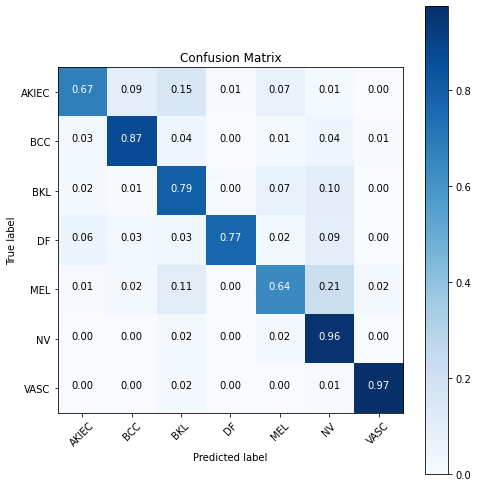

In [7]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [5]:
import disarray

# Instantiate the confusion matrix DataFrame with index and columns
#cm = confusion_matrix(a,b)
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.940378,0.962902,0.919510,0.965552,0.920172,0.926466,0.992713,0.946813
f1,0.745763,0.864407,0.741764,0.866324,0.702101,0.792523,0.975717,0.813846
false_discovery_rate,0.164557,0.139759,0.304781,0.011730,0.219780,0.325914,0.022124,0.186154
false_negative_rate,0.326531,0.131387,0.205011,0.228833,0.361798,0.038549,0.026432,0.186154
false_positive_rate,0.019794,0.022239,0.059302,0.001549,0.031080,0.079519,0.003899,0.031026
negative_predictive_value,0.952645,0.979263,0.964243,0.962659,0.939360,0.992887,0.995325,0.968974
positive_predictive_value,0.835443,0.860241,0.695219,0.988270,0.780220,0.674086,0.977876,0.813846
precision,0.835443,0.860241,0.695219,0.988270,0.780220,0.674086,0.977876,0.813846
recall,0.673469,0.868613,0.794989,0.771167,0.638202,0.961451,0.973568,0.813846
sensitivity,0.673469,0.868613,0.794989,0.771167,0.638202,0.961451,0.973568,0.813846
